In [2]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn_data = ({
    'USERNAME': 'postgres',
    'DB_NAME': 'iowa_liquor_sales',
    'PASSWORD': 'postgres',
    'HOST': 'localhost',
    'PORT': '5432'
})

In [4]:
view_name_1 = 'VolumeByCity'
query_1 = f'''
CREATE VIEW {view_name_1} AS
SELECT city, (volume * quantity) AS total_volume¶
FROM store_location
JOIN store USING(zip_code)
JOIN sale USING(store_name)
JOIN details USING(invoice)
JOIN description USING(item_num)
ORDER BY volume DESC
'''

In [5]:
view_name_2 = 'HighRetail'
query_2 = f'''
CREATE VIEW {view_name_2} AS
SELECT store_name, item_desc, retail
FROM sale
JOIN details USING(invoice)
JOIN description USING(item_num)
WHERE retail > (SELECT AVG(retail) FROM details)
'''

In [6]:
view_name_3 = 'TotalRetailByDate'
query_3 = f'''
CREATE VIEW {view_name_3} AS
SELECT (quantity * retail) AS total_retail, sale_date
FROM sale
JOIN details USING(invoice)
ORDER BY sale_date
'''

In [7]:
conn = psycopg2.connect(user=conn_data['USERNAME'], password=conn_data['PASSWORD'], dbname=conn_data['DB_NAME'], host=conn_data['HOST'], port=conn_data['PORT'])

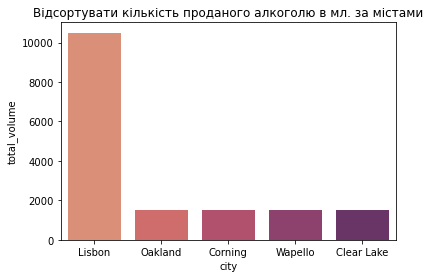

In [8]:
with conn:
    cur = conn.cursor()

    cur.execute(f'DROP VIEW IF EXISTS {view_name_1}')
    cur.execute(query_1)
    cur.execute(f'SELECT * FROM {view_name_1}')
    
    query = list()
    for row in cur:
        query.append([row[0], row[1]])

    df = pd.DataFrame(query, columns=['city', 'total_volume'])
    
    sns.barplot(x=df.city, y=df.total_volume, palette='flare')
    plt.title('Відсортувати кількість проданого алкоголю в мл. за містами')
    plt.show()

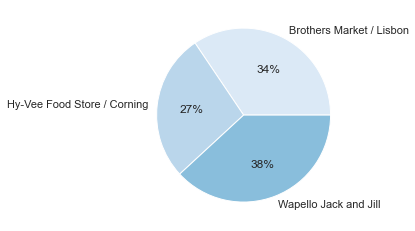

In [9]:
with conn:
    cur.execute(f'DROP VIEW IF EXISTS {view_name_2}')
    cur.execute(query_2)
    cur.execute(f'SELECT * FROM {view_name_2}')

    query = list()
    for row in cur:
        query.append([row[0], row[1], row[2]])

    df = pd.DataFrame(query, columns=['store_name', 'item_desc', 'retail'])

    sns.set_theme(palette='Blues')
    plt.pie(x=df.retail, labels=df.store_name, autopct='%.0f%%')
    plt.show()

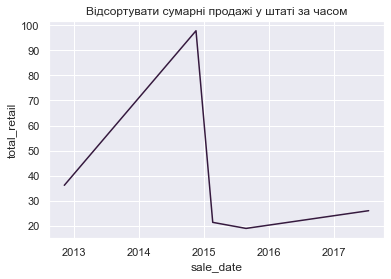

In [10]:
cur.execute(f'DROP VIEW IF EXISTS {view_name_3}')
cur.execute(query_3)
cur.execute(f'SELECT * FROM {view_name_3}')

query = list()
for row in cur:
    query.append([row[0], row[1]])

df = pd.DataFrame(query, columns=['total_retail', 'sale_date'])

sns.set_theme(palette='rocket')
sns.lineplot(x=df.sale_date, y=df.total_retail)
plt.title('Відсортувати сумарні продажі у штаті за часом')
plt.show()